In [31]:
import cv2
import numpy as np
import random
import math
from matplotlib import pyplot as plt

random.seed(42)

# SYSTEM PARAMETERS

You are free to change these but do not add extra variables here. This entire block will be replaced when marking.

You are free modify the parameters but not the variable names.

In [32]:
# DO NOT ADD OTHER VARIABLE HERE

# General settings
seed = 42
image_file = "sample_map.png"

# Task 1 - Occupancy map
unsafe_kernel_size = 7
unsafe_iterations = 3

# Task 3 - BFS
size_of_node_grid = 10
bfs_start_node = 0
bfs_end_node = 99

# Task 4 - PRM and Dijkstra
iterations = 500
k_connections = 3
max_connection_range = 100
start_location = (100,100)
goal_location = (450,450)

# Task 5 - RRT
goal_radius = 20
step = 40

# DO NOT ADD OTHER VARIABLE HERE

# Task 1 - OCCUPANCY MAP (4 marks total)

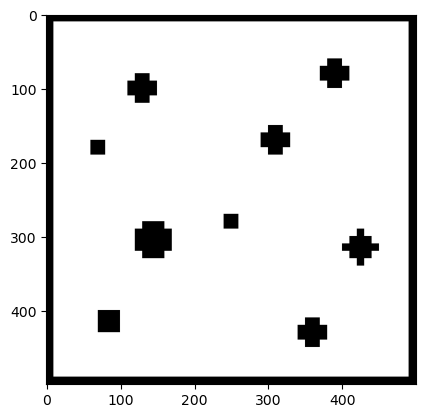

In [33]:
# Task 1.1 (1 mark): Display the occupancy map
image = cv2.imread(image_file) # TODO: Replace with code to load the image

# Display resulting image
plt.imshow(image)
plt.show()


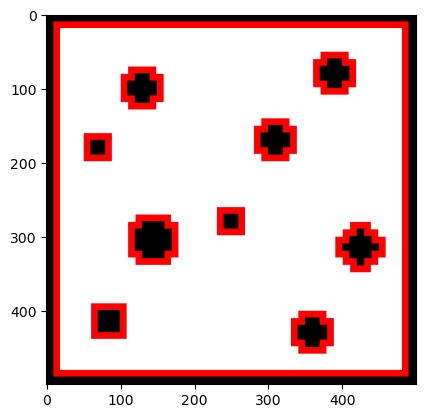

In [34]:
# Task 1.2 (2 Marks): Process occupancy map add and display configuration space
# author's note: task is to generate a red unsafe zone around map

kernel = np.ones((unsafe_kernel_size, unsafe_kernel_size), np.uint8) # TODO: Use this kernel to generate un_safe area

rgbimage = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray_image = cv2.cvtColor(rgbimage, cv2.COLOR_RGB2GRAY)
erosion = cv2.erode(gray_image, kernel, iterations=unsafe_iterations)
unsafe_mask = np.abs(gray_image-erosion)
unsafe_mask = unsafe_mask > 0
unsafe_zone = np.copy(rgbimage)
unsafe_zone[unsafe_mask] = [255, 0, 0]  # Selects unsafe pixel area '[]' and colores the unsafe zones red in BGR format

# Display resulting image with red unsafe zones
plt.imshow(unsafe_zone)  # Convert BGR to RGB for correct color display in matplotlib
plt.show()

# Task 2 - Graph Class (3 marks total)

NOTE: This is slightly different to the graph in lab 07. x,y variables have been added to the node object.

In [35]:
# Task 2.1 (3 marks):  Complete the graph class

class Node:
    def __init__(self, node_id, x, y):
        self.id = node_id
        self.x = x
        self.y = y
    
    def get_point(self):
        return (self.x,self.y)
    
    def get_ID(self):
        return self.id

class Graph:
    def __init__(self):
        self.nodes = {}
        self.edges = {}
        self.neighbors = {}

    def add_node(self, node_id, x, y):
        if node_id not in self.nodes:
            self.nodes[node_id] = Node(node_id, x, y)

    def add_edge(self, node_id1, node_id2, weight):
        if node_id1 in self.nodes and node_id2 in self.nodes:
            if node_id1 not in self.edges:
                self.edges[node_id1] = {}
            self.edges[node_id1][node_id2] = weight

    def remove_edge(self, node_id1, node_id2):
        if node_id1 in self.edges and node_id2 in self.edges[node_id1]:
            del self.edges[node_id1][node_id2]
    
    def get_nodes(self):
        return list(self.nodes.values())
    
    def get_edge_weight(self, node_id1, node_id2):
        if node_id1 in self.edges and node_id2 in self.edges[node_id1]:
            return self.edges[node_id1][node_id2]
        return None
    # helper function to help print out nodes and edges
    def print_nodes(self):
        print("Nodes:")
        for node_id, node in self.nodes.items():
            x, y = node.get_point()
            print(f"Node ID: {node_id}, Coordinates: ({x}, {y})")

    def print_edges(self):
        print("\nEdges:")
        for node_id1, connections in self.edges.items():
            for node_id2, weight in connections.items():
                print(f"Edge from Node {node_id1} to Node {node_id2} with weight {weight}")    
    
    # Helper function to clear all nodes and edges
    def clear_graph(self):
        self.nodes.clear()
        self.edges.clear()
        
    # Helper function to store unique neighbors
    def add_neighbors(self, node_id, neighbor_id, connections):
        if node_id in self.nodes:
            self.neighbors[node_id] = []
        if len(self.neighbors[node_id]) < connections:
            # Makes sure they're not each other's neighbors
            if (neighbor_id not in self.neighbors[node_id]) and (node_id not in self.neighbors[neighbor_id]):
                self.neighbors[node_id].append(neighbor_id)
                return True
            
    
    # Helper function to get node neighbors
    def get_neighbors(self, node):
        return self.edges.get(node, {}).items()
#--------------------------------------------------------------------------------------
#----------------------------------TESTING CODE----------------------------------------
#---------------------- uncomment lines below to test ---------------------------------
#--------------------------------------------------------------------------------------


# Create a Graph instance
#graph = Graph()

# Add nodes
#graph.add_node(1, 0, 0)
#graph.add_node(2, 2, 3)
#graph.add_node(3, 4, 6)

# Add edges
#graph.add_edge(1, 2, 10)
#graph.add_edge(2, 3, 20)

# Print nodes
#print("Nodes:")
#for node in graph.get_nodes():
#    print(f"ID: {node.get_ID()}, Point: {node.get_point()}")

# Print edges with weights
#print("\nEdges with weights:")
#for node_id1 in graph.edges:
#    for node_id2 in graph.edges[node_id1]:
#        weight = graph.get_edge_weight(node_id1, node_id2)
#        print(f"Edge from {node_id1} to {node_id2}, Weight: {weight}")

# Remove an edge
#graph.remove_edge(1, 2)
#graph.remove_edge(2, 3)
#print("\nEdges after removing the edge from 1 to 2:")
#for node_id1 in graph.edges:
#    for node_id2 in graph.edges[node_id1]:
#        weight = graph.get_edge_weight(node_id1, node_id2)
#        print(f"Edge from {node_id1} to {node_id2}, Weight: {weight}")

# Try to get the weight of a non-existent edge
#print("\nWeight of a non-existent edge (1 to 3):", graph.get_edge_weight(1, 3))


#-------------------------------------------------------------------------------------

# Task 3 - BFS (8 marks total)

In [36]:
# This is a useful function which you may choose to impliment and use 
# It looks through the image to see if the path is clear between one cooridnate to the next
# Returns True or False 
def path_clear(image, x1, y1, x2, y2):
    # Ensure the image has three channels (convert grayscale to BGR if needed)
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    # Initializing clear
    clear = True
    
    # Check if the coordinates are adjacent to each other
    if y1 == y2:
        # Loop through all x from x1 until it reaches x2
        start, end = sorted([x1, x2])
        for x in range(start, end + 1):
            if np.array_equal(image[y1, x], [0, 0, 255]):
                clear = False
            if np.array_equal(image[y1, x], [255, 0, 0]):
                clear = False
            if np.array_equal(image[y1, x], [0, 0, 0]):
                clear = False
    elif x1 == x2:
        # Loop through all y from y1 until it reaches y2
        start, end = sorted([y1, y2])
        for y in range(start, end + 1):
            if np.array_equal(image[y, x1], [0, 0, 255]):
                clear = False
            if np.array_equal(image[y, x1], [255, 0, 0]):
                clear = False
            if np.array_equal(image[y, x1], [0, 0, 0]):
                clear = False
    else:
        # If not horizontal/vertically aligned
        
        # The line below is sourced from: 
        # https://www.geeksforgeeks.org/bresenhams-line-generation-algorithm/
        # Use Bresenham's line algorithm to check pixels between (x1, y1) and (x2, y2)
        dx = abs(x2 - x1)
        dy = abs(y2 - y1)
        sx = 1 if x1 < x2 else -1
        sy = 1 if y1 < y2 else -1
        err = dx - dy
        
        while clear:
            if np.array_equal(image[y1, x1], [0, 0, 255]):
                clear = False
            if np.array_equal(image[y1, x1], [255, 0, 0]):
                clear = False
            if np.array_equal(image[y1, x1], [0, 0, 0]):
                clear = False
            if (x1 == x2) and (y1 == y2):
                break
            e2 = err * 2
            if e2 > -dy:
                err -= dy
                x1 += sx
            if e2 < dx:
                err += dx
                y1 += sy
    
    return clear


# Testing Code

# Define coordinates
#x1, y1, x2, y2 = 300, 410, 400, 410  # Horizontal path

# Call the function
#result = path_clear(image, x1, y1, x2, y2)
#plt.imshow(image) # needs to convert to rgb to show correct color
#plt.show()
#print('Path clear:', result)

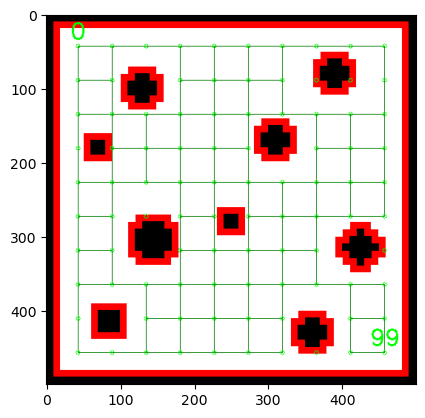

In [37]:
# Task 3.1 (4 marks): Generate a grid of nodes and connect the edges
bfs_image = unsafe_zone.copy() # Change to image once done testing
bfs_graph = Graph()

# Define visual elements
# Circle
circle_color = (0, 255, 0)  # Light Green in BGR format
circle_thickness = 1
# Line
line_color = [0, 125, 0]
line_thickness = 1

# Grid Generation - main loop
# Node grid parameters
node_counter = 0
image_size = 500            
circle_radius = 3  
circle_distance = image_size // size_of_node_grid - 4 # The bigger the denom. the closer it is to wall border hence the -4
# Calculate the offset to center the grid
grid_size = circle_distance * size_of_node_grid
offset_x = (image_size - grid_size) // 2
offset_y = (image_size - grid_size) // 2

for j in range(size_of_node_grid):
    for i in range(size_of_node_grid):
        # Draw nodes
        center_x = i * circle_distance + circle_distance // 2 + offset_x
        center_y = j * circle_distance + circle_distance // 2 + offset_y
        center = (center_x, center_y)
        node_x, node_y = center 
        if np.array_equal(image[center_y, center_x], [255, 255, 255]):
            cv2.circle(bfs_image, center, circle_radius, circle_color, circle_thickness)
        bfs_graph.add_node(node_counter, node_x, node_y) # Adds node to graph class
        
        # Draw lines
        # Connect to the right neighbor
        if i < size_of_node_grid - 1:
            right_center_x = (i + 1) * circle_distance + circle_distance // 2 + offset_x
            right_center_y = center_y
            right_center = (right_center_x, right_center_y)
            right_x, right_y = right_center
            check_path = path_clear(bfs_image, node_x, node_y, right_x, right_y)
            if check_path:
                cv2.line(bfs_image, center, right_center, line_color, line_thickness)

        # Connect to the bottom neighbor
        if j < size_of_node_grid - 1:
            bottom_center_x = center_x
            bottom_center_y = (j + 1) * circle_distance + circle_distance // 2 + offset_y
            bottom_center = (bottom_center_x, bottom_center_y)
            bottom_x, bottom_y = bottom_center
            check_path = path_clear(bfs_image, node_x, node_y, bottom_x, bottom_y)
            if check_path:
                cv2.line(bfs_image, center, bottom_center, line_color, line_thickness)
        
        # Prints label if its the first and last node
        if i == 0 and j == 0:
            cv2.putText(bfs_image, str(node_counter), (node_x-10, node_y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        elif i == size_of_node_grid - 1 and j == size_of_node_grid - 1:
            cv2.putText(bfs_image, str(node_counter), (node_x-19, node_y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        node_counter += 1

# Add edges to validly connected nodes after all nodes have been stored in class
for node_id, node in bfs_graph.nodes.items():
    x, y = node.get_point()
    # Calculate the positions of right and bottom neighbors
    right_node_id = node_id + 1
    bottom_node_id = node_id + size_of_node_grid
    # Check if the right neighbor exists
    if right_node_id in bfs_graph.nodes:
        right_node = bfs_graph.nodes[right_node_id]
        right_x, right_y = right_node.get_point()
        if path_clear(bfs_image, x, y, right_x, right_y):
            bfs_graph.add_edge(node_id, right_node_id, 1)       
    # Check if the bottom neighbor exists
    if bottom_node_id in bfs_graph.nodes:
        bottom_node = bfs_graph.nodes[bottom_node_id]
        bottom_x, bottom_y = bottom_node.get_point()
        # Check if the path to the bottom neighbor is clear
        if path_clear(bfs_image, x, y, bottom_x, bottom_y):
            bfs_graph.add_edge(node_id, bottom_node_id, 1) 
    
# Display Resulting Image
# plt.imshow(cv2.cvtColor(bfs_image, cv2.COLOR_BGR2RGB)) # Display in RGB for matplotlib
plt.imshow(bfs_image) # Display in RGB for matplotlib

plt.show()


##############################################################################

# Testing code to print out nodes and edges
# Print all nodes and their coordinates
#bfs_graph.print_nodes()

# Print all edges and their connections
#bfs_graph.print_edges()

In [38]:
# Task 3.2 (4 marks): Impliment BFS

# Returns an array of nodes in order of which nodes is visited next.
# ie. [0, 10, 20, 30, 40, 50, 60, 70, 71, 72, 73, 74, 75, 76, 77, 78, 88, 98, 99]
def bfs(graph, start_node_id, end_node_id):
    # FIFO - first in first out
    # Bottom first and then right neighbour
    path = []
    visited = set()
    queue = deque([start_node_id])
    parent = {start_node_id: None} # Creates dictionary to keep track of each current node's parent node
    
    # Traverse graph bottom first and then right neighbor
    while queue:
        current_node = queue.popleft()
        if current_node == end_node_id: # Checks if loop reaches the end node
            break
        current_x, current_y = graph.nodes[current_node].get_point()
    
        # Check bottom neighbour first
        bottom_node_id = current_node + size_of_node_grid # Gets bottom node id
        if bottom_node_id in graph.nodes and bottom_node_id not in visited:
            bottom_x, bottom_y = graph.nodes[bottom_node_id].get_point()
            if path_clear(bfs_image, current_x, current_y, bottom_x, bottom_y):
                queue.append(bottom_node_id)
                visited.add(bottom_node_id)
                parent[bottom_node_id] = current_node
                
        # Check right neighbour afterwards
        right_node_id = current_node + 1 # Gets right node id
        if right_node_id in graph.nodes and right_node_id not in visited:
            right_x, right_y = graph.nodes[right_node_id].get_point()
            if path_clear(bfs_image, current_x, current_y, right_x, right_y):
                queue.append(right_node_id)
                visited.add(right_node_id)
                parent[right_node_id] = current_node
            
    # Loop backwards
    step = end_node_id
    while step is not None:
        path.append(step) # Add last node to path
        step = parent[step] # Move to the parent of current node
    path.reverse()
    return path

# testing code
path = bfs(bfs_graph,bfs_start_node,bfs_end_node)
#current_node_id = path[5]
print(f"Path: {path}")


Path: [0, 10, 20, 30, 40, 50, 60, 70, 71, 72, 73, 74, 75, 76, 77, 78, 88, 98, 99]


Path: [0, 10, 20, 30, 40, 50, 60, 70, 71, 72, 73, 74, 75, 76, 77, 78, 88, 98, 99]


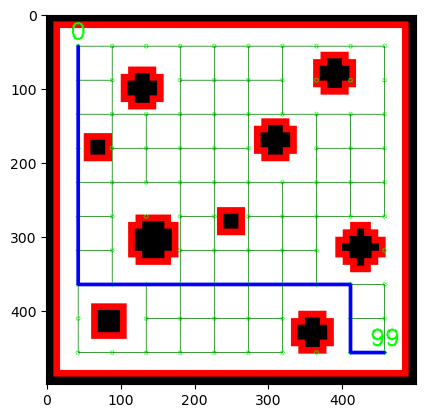

In [39]:
# Task 3.2: Impliment BFS continued

# Run bfs and display the output
path = bfs(bfs_graph,bfs_start_node,bfs_end_node)

for i in range(len(path) - 1):
    current_point = bfs_graph.get_nodes()[path[i]].get_point()
    next_point = bfs_graph.get_nodes()[path[i+1]].get_point()
    cv2.line(bfs_image, current_point, next_point, (0, 0, 255), 3)

# Display resulting image
print(f"Path: {path}")
# plt.imshow(cv2.cvtColor(bfs_image, cv2.COLOR_BGR2RGB))
plt.imshow(bfs_image)
plt.show()

# Task 4 -  PRM and Dijkstra Algorithm (6 marks total)

In [40]:
# This is a useful function which you may choose to impliment and use 
# It finds and returns the n closest nodes which are within the range
def find_closest_nodes(image,graph, target_x, target_y, n,neighbor_radius):
    # Ensures image is in BGR
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)    
    distances = []
    for node_id, node in graph.nodes.items():
        node_x, node_y = node.get_point()
        if node_x == target_x and node_y == target_y:
            continue
        distance = np.linalg.norm(np.array([node_x, node_y]) - np.array([target_x, target_y])) 
        # Checks if node is within radius - adds if yes
        if distance <= neighbor_radius:
            if distance > 0:
                distances.append((node_id, distance))    
    distances.sort(key=lambda x: x[1])
    return distances[:n] # Returns the n smallest distances after distance has been populated


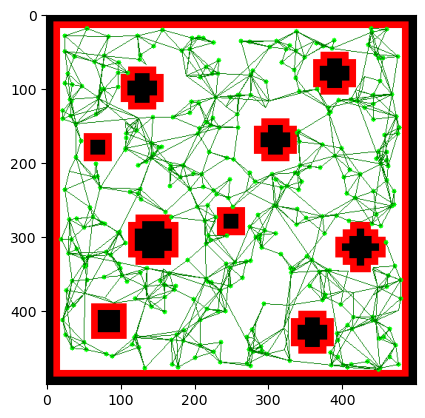

In [41]:
# Task 4.1 (3 marks): PRM
# NOTE: The iteration only increases when a valid node is placed on the map. If the node is invalid, the program should continue without incrementing the iteration count. 

prm_image = unsafe_zone.copy()
prm_graph = Graph()
random.seed(seed)

# Nodes as a random sample
i = 0
while i < iterations:
    x = random.randint(0, prm_image.shape[0]-1)
    y = random.randint(0, prm_image.shape[1]-1)
    if np.array_equal(prm_image[x, y], [255, 255, 255]):
        prm_graph.add_node(i, y, x)
        closest_nodes = find_closest_nodes(prm_image,prm_graph, y, x, k_connections,max_connection_range)
        for neighbour_node_id, distance in closest_nodes:
            prm_graph.add_edge(i, neighbour_node_id, distance)
            prm_graph.add_edge(neighbour_node_id, i, distance)
    i += 1

for node in prm_graph.get_nodes():
    x,y = node.get_point()
    if np.array_equal(prm_image[x,y], [255,255,255]):
        cv2.circle(prm_image, (x,y), 3, (0, 255, 0), -1)
for node_1_id, connections in prm_graph.edges.items():
    node_1 = prm_graph.nodes[node_1_id]
    coord1 = (int(node_1.get_point()[0]), int(node_1.get_point()[1]))
    x1,y1 = coord1
    for node_2_id, weight in connections.items():
        node_2 = prm_graph.nodes[node_2_id]
        coord2 = (int(node_2.get_point()[0]), int(node_2.get_point()[1]))
        x2,y2 = coord2
        if path_clear(prm_image, x1, y1, x2, y2):
            cv2.line(prm_image, coord1, coord2, (0, 125, 0), 1)

# Display resulting image
# plt.imshow(cv2.cvtColor(prm_image, cv2.COLOR_BGR2RGB))
plt.imshow(prm_image)
plt.show()

# Test code for nodes
#prm_graph.print_nodes()
# prm_graph.print_edges()
#print(f"Path: {next_point}")

In [42]:
# Task 4.2 (3 marks): Djistraks
# Example output - Path: [-1, 143, 43, 1, 14, 44, 67, 7, 9, 4, 12, 364, -2], Cost: 561.9189671797234

def dijkstra(graph, start_id, end_id):    
    path = []
    final_cost = 0
    total_cost = {start_id: 0}
    visited = set()
    queue = deque()
    parent = {start_id: None} 
    
    queue.append(start_id)
    while queue:
        current_id = min(queue, key=lambda node: total_cost.get(node, float('inf')))
        queue.remove(current_id)
        if current_id == end_id: # Breaks out of loop if reaches the end
            break
        visited.add(current_id)
    
        for node in prm_graph.get_nodes():
            check_edges = prm_graph.get_edge_weight(current_id, node.get_ID())
            # If there are valid edges and we haven't visited them, find shortest distance
            if check_edges is not None and node.get_ID() not in visited:
                current_cost = total_cost[current_id] + prm_graph.get_edge_weight(current_id, node.get_ID())
                if node.get_ID() not in total_cost or current_cost < total_cost[node.get_ID()]:
                    total_cost[node.get_ID()] = current_cost
                    parent[node.get_ID()] = current_id
                    queue.append(node.get_ID())
    
    path = []
    step = end_id
    while step is not None:
        path.append(step)
        step = parent.get(step)
    path.reverse()
    
    for i in range(len(path) - 1):
        node_id1 = path[i]
        node_id2 = path[i + 1]
        edge_weight = graph.get_edge_weight(node_id1, node_id2)
        final_cost += edge_weight
            
    return (path, final_cost)

Path: [-1, 421, 57, 2, 22, 58, 409, 389, 199, 94, 11, 14, 5, 18, 467, -2], Cost: 563.0721423760862


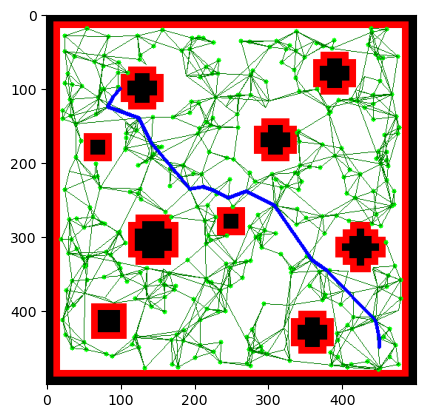

In [43]:
# Task 4.2: Djistraks continued
# NOTE TO MARKER: run back from 4.1 until this segment to regenerate the path 
#                 if you wanna see the second time! Thank you *smiley face*

# Add start (node id = -1) and end (node_id = -2 ) nodes 
id_start = -1
id_goal = -2

# Clean up any possible leftover edge connections from test code
for node in prm_graph.get_nodes():
    prm_graph.remove_edge(node.get_ID(), id_start)
    prm_graph.remove_edge(node.get_ID(), id_goal)
    prm_graph.remove_edge(id_start, node.get_ID())
    prm_graph.remove_edge(id_goal, node.get_ID())

start_x, start_y = start_location
goal_x, goal_y = goal_location

prm_graph.add_node(-1,start_x,start_y) # start node
prm_graph.add_node(-2,goal_x,goal_y) # end node

start_closest_nodes = find_closest_nodes(prm_image,prm_graph, start_x, start_y, k_connections,max_connection_range)
goal_closest_nodes = find_closest_nodes(prm_image,prm_graph, goal_x, goal_y, k_connections,max_connection_range)

for neighbor_node_id, distance in start_closest_nodes:
    for node in prm_graph.get_nodes():
        if node.get_ID() == neighbor_node_id:
            neighbor_coordinate = node.get_point()
            neighbor_x, neighbor_y = neighbor_coordinate
            if path_clear(prm_image, start_x, start_y, neighbor_x, neighbor_y):
                prm_graph.add_edge(id_start, neighbor_node_id, distance)
                prm_graph.add_edge(neighbor_node_id, id_start, distance)
#                 cv2.line(prm_image, start_location, neighbor_coordinate, (0, 125, 0), 1)

for neighbor_node_id, distance in goal_closest_nodes:
    for node in prm_graph.get_nodes():
        if node.get_ID() == neighbor_node_id:
            neighbor_coordinate = node.get_point()
            neighbor_x, neighbor_y = neighbor_coordinate
            if path_clear(prm_image, goal_x, goal_y, neighbor_x, neighbor_y):
                prm_graph.add_edge(id_goal, neighbor_node_id, distance)
                prm_graph.add_edge(neighbor_node_id, id_goal, distance)
#                 cv2.line(prm_image, goal_location, neighbor_coordinate, (0, 125, 0), 1)                


path, totcost = dijkstra(prm_graph, id_start, id_goal)

# Drawing
point_x = []
point_y = []
for node_id in path:
    for node in prm_graph.get_nodes():
        if node.get_ID() == node_id:
            x,y = node.get_point()
            point_x.append(x)
            point_y.append(y)

for i in range(len(point_x) - 1):
    start_point = (point_x[i], point_y[i])
    end_point = (point_x[i + 1], point_y[i + 1])
    cv2.line(prm_image, start_point, end_point, (0, 0, 255), 3)
    
# Display resulting image
print(f"Path: {path}, Cost: {totcost}")
plt.imshow(prm_image)
plt.show()


# Task 5 - Rapidly-exploring random trees (RRT) (4 marks total)

In [44]:
# This is a useful function which you may choose to impliment and use 
# Given a random point it extends the tree by either the step distance or the cartesian distance
def calculate_new_tree_point( x_closest, y_closest, x, y,step):

    x = 0
    y = 0
    distance = 0
    
    return x, y, distance
    

# This is a useful function which you may choose to impliment and use 
# It finds and returns the closest node to a point on the image
def find_closest_node_rrt(graph, target_x, target_y):

    distances = []

    return distances[0]


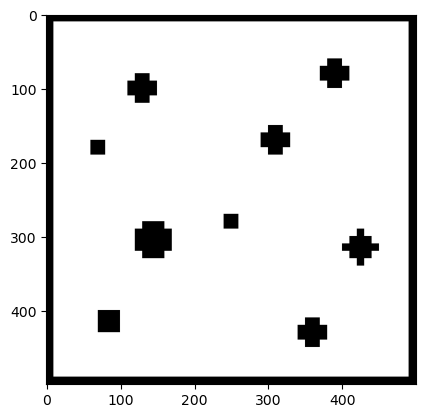

In [45]:
# Task 5.1 (3 marks): RRT/RRT*
# Use the same start and goal locations as PRM 

# NOTE: for this implimentation the next iteration is reach only if a valid node is placed
# If, from the source location there is no valid path to the newly placed node. Then the iteration is repeated and a new random x,y location are selected 

rrt_image = cv2.imread(image_file)
rrt_graph = Graph()
random.seed(seed)

# Generate the start node with a node_ID of -1

i = 0
while i < iterations:
    
    x = random.randint(0, rrt_image.shape[0]-1)
    y = random.randint(0, rrt_image.shape[1]-1)
    
    i += 1


# Display resulting image
plt.imshow(rrt_image)
plt.show()


#### Task 5.2 (1 mark) - Provide a pharagraph about informed RRT, discuss the advantages proposed in the paper.

Provide your answer in this markdown box:

The paper first discusses the limitations of the RRT* algorithm, which aims to find optimal solutions by exploring every state from the initial point in the path-planning area. The proposed solution improves both the convergence rate and the quality of the final solution by introducing a method called direct sampling of an ellipsoidal subset. This method involves focusing on a smaller, more relevant area shaped like a prolate hyperspheroid, with the start and goal states as focal points. By concentrating on this subset, Informed RRT* can find near-optimal solutions more quickly and reliably, regardless of the problem's complexity. Unlike RRT*, which relies on random sampling and struggles with large or complex problems, Informed RRT* uses heuristics to efficiently narrow down the search. Current research is also exploring improvements such as Batch Informed Trees (BIT*), which gradually expand the search area to prioritize finding better solutions earlier.